In [2]:
import os
import copy
import time
import random
import numpy as np

import functools

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

SEED = 241

In [3]:
def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [186]:
class EMNISTDataset(data.Dataset):

  def __init__(self, train: bool = True, 
               max_seq_len: int = 1, 
               blank_label = 11,
               pad_label = 10,
               img_size: [int, int] = (28, 28)):
      self.dataset = datasets.MNIST(root='./data', train=train, download=True)
      self.max_seq_len = max_seq_len
      self.img_size = img_size

  def __getitem__(self, index):
    labels = []
   
    image_seq = np.zeros((self.img_size[0], self.img_size[1] * self.max_seq_len))
    seq_len = random.randint(self.max_seq_len // 2, self.max_seq_len)
    bias = abs(np.random.normal(loc=0, scale=5, size=(seq_len,)))
    
    for i in range(0, seq_len):
      index = random.randint(0, self.dataset.train_data.size(0) - 1)
      image, label = self.dataset[index]
      image = np.array(image) / 255
      insert_pos = np.array([i * image.shape[1], (i + 1) * image.shape[1]])
      
      if i > 0:
        insert_pos -= int(bias[i])
      
      image_seq[:, insert_pos[0]: insert_pos[1]] += image
      image_seq = np.clip(image_seq, 0, 1)
      labels.append(label)
    
    labels_len = torch.IntTensor([len(labels)])
    labels.extend([pad_label] * (self.max_seq_len - seq_len))
    
    image_seq = torch.FloatTensor([image_seq])
    labels = torch.LongTensor([labels])
    
    return image_seq, labels, labels_len

  def __len__(self):
    return 10000

In [199]:
pad_label = 10
blank_label = 11
dataset = EMNISTDataset(train=True, max_seq_len=10, pad_label=pad_label, blank_label=blank_label)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


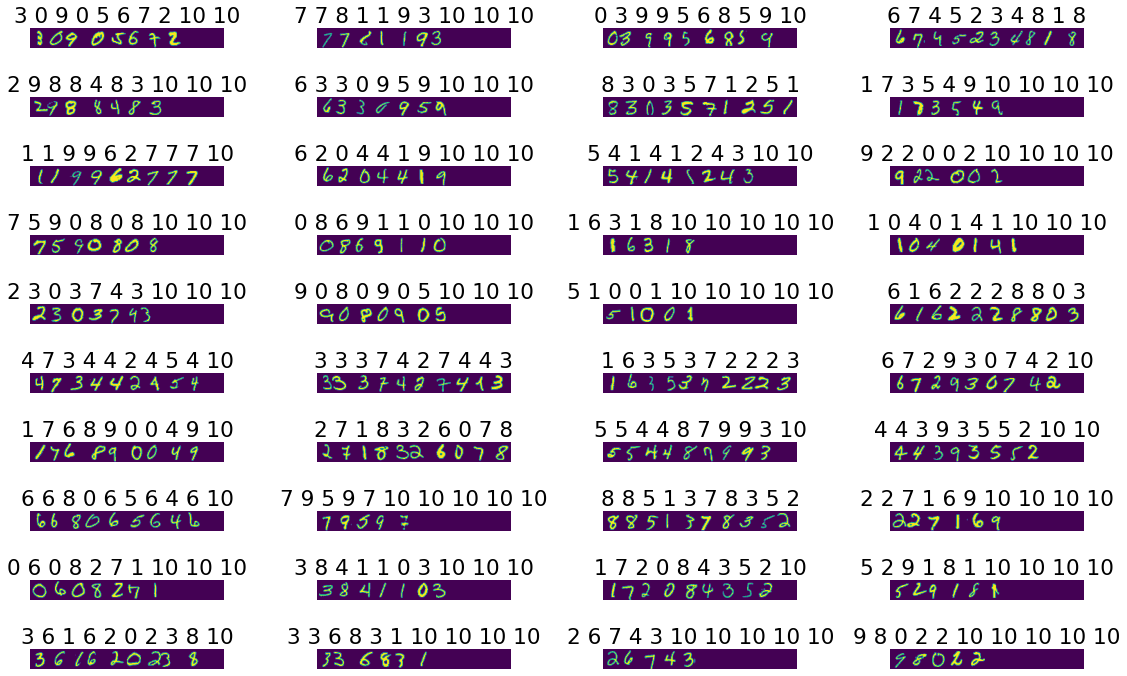

In [191]:
n_images = 40
n_cols = 4
n_rows = n_images // n_cols + 1

fig = plt.figure(10, figsize=(n_cols * 4, n_rows))

for num in range(n_images):
  i = num // n_cols
  j = num % n_cols
  train_img_tensor, labels_tenzor, labels_lens = dataset[i]
  ax = fig.add_subplot(n_rows, n_cols, i  * n_cols + j + 1)
  ax.set_title(' '.join([str(label.item()) for label in labels_tenzor[0] if label.item() != blank_label]))
  ax.imshow(train_img_tensor[0])
  ax.axis('off')
plt.tight_layout()

In [249]:
class RCNN(nn.Module):

  def __init__(self,
               num_classes,
               cnn_input_image_size, 
               cnn_channels_list, 
               cnn_kernel_size=(3, 3), 
               rnn_hidden=256,
               rnn_n_layers=4, 
               rnn_dropout=0.3):
    super().__init__()

    features = []
    image_size = cnn_input_image_size

    for n in range(len(cnn_channels_list)):
      if n % 2:
        features.append(nn.Conv2d(in_channels=cnn_channels_list[n][0],
                                  out_channels=cnn_channels_list[n][1],
                                  kernel_size=cnn_kernel_size, 
                                  stride=2))
      else:
        features.append(nn.Conv2d(in_channels=cnn_channels_list[n][0],
                                  out_channels=cnn_channels_list[n][1],
                                  kernel_size=cnn_kernel_size, 
                                  stride=1))
      features.append(nn.LeakyReLU(0.1))
      features.append(nn.BatchNorm2d(cnn_channels_list[n][1]))
      image_size = ((image_size[0] - cnn_kernel_size[0]) // (1 + int(n % 2)) + 1, 
                    (image_size[1] - cnn_kernel_size[1]) // (1 + int(n % 2)) + 1)
      # print(image_size)

    self.image_features = nn.Sequential(*features)
    
    rnn_input_size = image_size[0] * cnn_channels_list[-1][-1]
    self.rnn_hidden = rnn_hidden
    self.rnn = nn.LSTM(rnn_input_size,
                       rnn_hidden, 
                       num_layers=rnn_n_layers,
                       batch_first=True, 
                       dropout=rnn_dropout,
                       bidirectional=True)
    
    self.fc = nn.Linear(rnn_hidden * 2, num_classes)
  
  def forward(self, image):
    bs = image.shape[0]
    
    cnn_features = self.image_features(image)
    # print(cnn_features.shape)
    
    seq_len = cnn_features.shape[-1]
    cnn_features = cnn_features.permute(0, 3, 2, 1).contiguous()
    rnn_input = cnn_features.view(bs, seq_len, -1)
    
    rnn_output, (rnn_hidden, rnn_cell) = self.rnn(rnn_input)
    
    output = torch.stack([F.log_softmax(self.fc(rnn_output[i]), dim=-1) 
                          for i in range(rnn_output.shape[0])])
    return output

In [250]:
num_classes = 10 + 1 + 1
input_size = (28, 28)
channels_list = [(1, 32), (32, 32), (32, 64), (64, 64)]

rcnn = RCNN(num_classes,
            input_size, 
            channels_list, 
            cnn_kernel_size=(2, 2), 
            rnn_hidden=256,
            rnn_n_layers=4,
            rnn_dropout=0.3)

dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = opt.Adam(rcnn.parameters(), lr=1e-4)

rcnn = rcnn.to(device)
criterion = criterion.to(device)

In [257]:
epochs = 10
num_classes = 12
blank_label = 10
pad_label = 11
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 6
cnn_output_width = 104
digits_per_sequence = 15
number_of_sequences = 10000
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
dataset_sequences = []
dataset_labels = []

input_size = (28, 28)
channels_list = [(1, 32), (32, 32), (32, 64), (64, 64)]

rcnn = RCNN(num_classes,
            input_size, 
            channels_list, 
            cnn_kernel_size=(2, 2), 
            rnn_hidden=256,
            rnn_n_layers=4,
            rnn_dropout=0.3)

for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0)
        img = TF.hflip(img)
        # img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_images[-5:, :, :] = 0
    random_digits_labels = emnist_dataset.targets[random_indices]
    random_digits_labels[-5:] = pad_label
    if i % 2:
      random_digits_images[-7:-5, :, :] = 0
      random_digits_labels[-7: -5] = pad_label
    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 28, 28)))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)


model = rcnn.to(gpu)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

TRAINING. Correct:  0 / 8000 = 0.0
1.9311863641738891
TESTING. Correct:  0 / 2000 = 0.0
TRAINING. Correct:  0 / 8000 = 0.0
1.0308106360435485
TESTING. Correct:  0 / 2000 = 0.0
TRAINING. Correct:  9 / 8000 = 0.001125
0.15306734025478363
TESTING. Correct:  20 / 2000 = 0.01
TRAINING. Correct:  11 / 8000 = 0.001375
0.11096755081415176
TESTING. Correct:  6 / 2000 = 0.003
TRAINING. Correct:  289 / 8000 = 0.036125
0.09712738704681396
TESTING. Correct:  80 / 2000 = 0.04
TRAINING. Correct:  382 / 8000 = 0.04775
0.09244163119792938
TESTING. Correct:  196 / 2000 = 0.098
TRAINING. Correct:  882 / 8000 = 0.11025
0.08313414919376373
TESTING. Correct:  308 / 2000 = 0.154
TRAINING. Correct:  1773 / 8000 = 0.221625
0.07772614926099777
TESTING. Correct:  692 / 2000 = 0.346
TRAINING. Correct:  2957 / 8000 = 0.369625
0.07942745107412338
TESTING. Correct:  94 / 2000 = 0.047
TRAINING. Correct:  3902 / 8000 = 0.48775
0.06369178120791912
TESTING. Correct:  1805 / 2000 = 0.9025


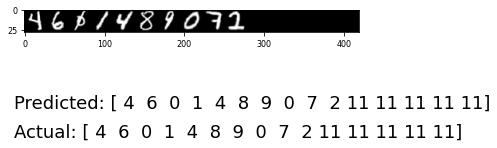

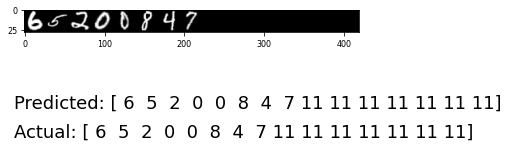

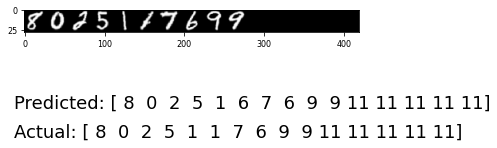

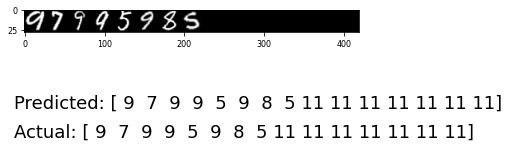

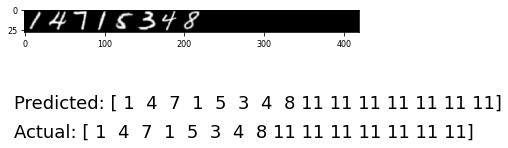

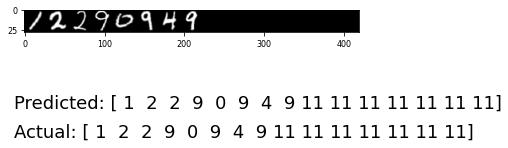

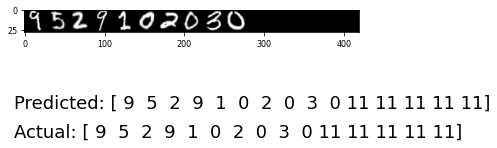

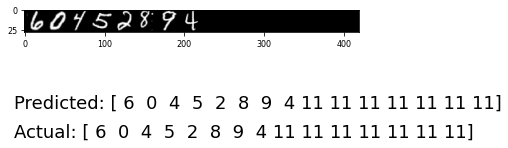

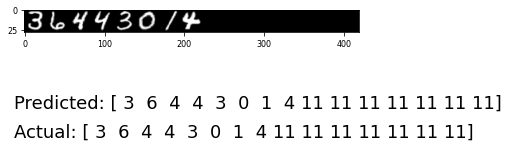

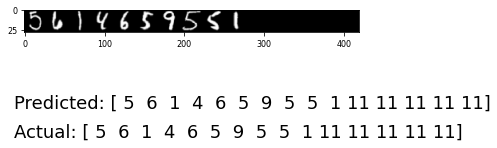

In [258]:
# ================================================ TRAINING MODEL ======================================================
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    error = 0

    for x_train, y_train in train_loader:
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([sum(t != blank_label) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        error += loss.item()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)
    print(error / len(train_loader))

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    with torch.no_grad():
      for x_val, y_val in val_loader:
          batch_size = x_val.shape[0]
          x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
          y_pred = model(x_val.cuda())
          y_pred = y_pred.permute(1, 0, 2)
          input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
          target_lengths = torch.IntTensor([len(t) for t in y_val])
          criterion(y_pred, y_val, input_lengths, target_lengths)
          _, max_index = torch.max(y_pred, dim=2)
          for i in range(batch_size):
              raw_prediction = list(max_index[:, i].detach().cpu().numpy())
              prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
              if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                  val_correct += 1
              val_total += 1
      print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()